# 2021-01-01 • Influence of simulation params on connection test

Here for the first time we run the entire workflow / 'loop' in one function (biology & imaging simulation, plus connection test). We then call this function with varying parameters, to test thei influence  how well the connection test performs.

We stimulate the neuron with multiple spike trains, but only test the connection with one spike train (because it's easier and faster), for now.

## Setup

In [1]:
from voltage_to_wiring_sim.support.notebook_init import *

Preloading:
 - numpy … (0.10 s)
 - matplotlib.pyplot … (0.22 s)
 - numba … (0.30 s)

Importing from submodules … ✔

Imported `np`, `mpl`, `plt`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga`<br>on **Sat 02 Jan** 2021, at 00:25 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/37eb33d1b36a9c7ecefe9bf40b9252eae65b0407
) (Fri 01 Jan 2021, 23:38).

Uncommited changes to:
```
?? notebooks/2020_12_30__vary_params.ipynb
```

## Base parameters

In [3]:
default_sim_params = v.N_to_1_simulation.default_params
v.pprint(default_sim_params)

N_to_1_SimParams
----------------
                time_grid = {'duration': 600, 'start': 0, 'timestep': 0.0001}
num_incoming_spike_trains = 15
               spike_rate = 20
                   Δg_syn = 8E-10
                    τ_syn = 0.007
            neuron_params = {'C': 1e-10, 'a': 30.0, 'b': -2e-09, 'c': -0.05, ...}
        imaging_spike_SNR = 10


(All quantities are in unprefixed SI units: second, Hz, Farad, Siemens …. Pretty printing, in human readable units, is not here yet).

In [4]:
def sim_and_test(params, zoom_start=1 * second):
    
    v.fix_rng_seed()
    
    sim_result = v.N_to_1_simulation.simulate(params)
    
    zoom_window = v.TimeGrid(start=zoom_start, duration=1 * second,
                             timestep=params.time_grid.timestep)
    v.N_to_1_simulation.plot(sim_result, zoom_window)
    plt.show()  # don't wait till function has completed to show plot.
    
    spike_train = sim_result.spike_trains[0]
    window_duration = 100 * ms
    
    STA = v.calculate_STA(sim_result.VI_signal, spike_train, window_duration)
    
    test_data, test_summary = v.test_connection(
        spike_train,
        sim_result.VI_signal,
        window_duration,
        num_shuffles=100,
    )
    
    fig, (left_ax, right_ax) = plt.subplots(ncols=2, **v.figsize(width=700, aspect=3))
    v.plot_STA(STA, left_ax)
    left_ax.set_ylabel("STA of VI signal (mV)")
    v.connection_test.plot(test_data, ax=right_ax)
    plt.show()
    v.pprint(test_summary)

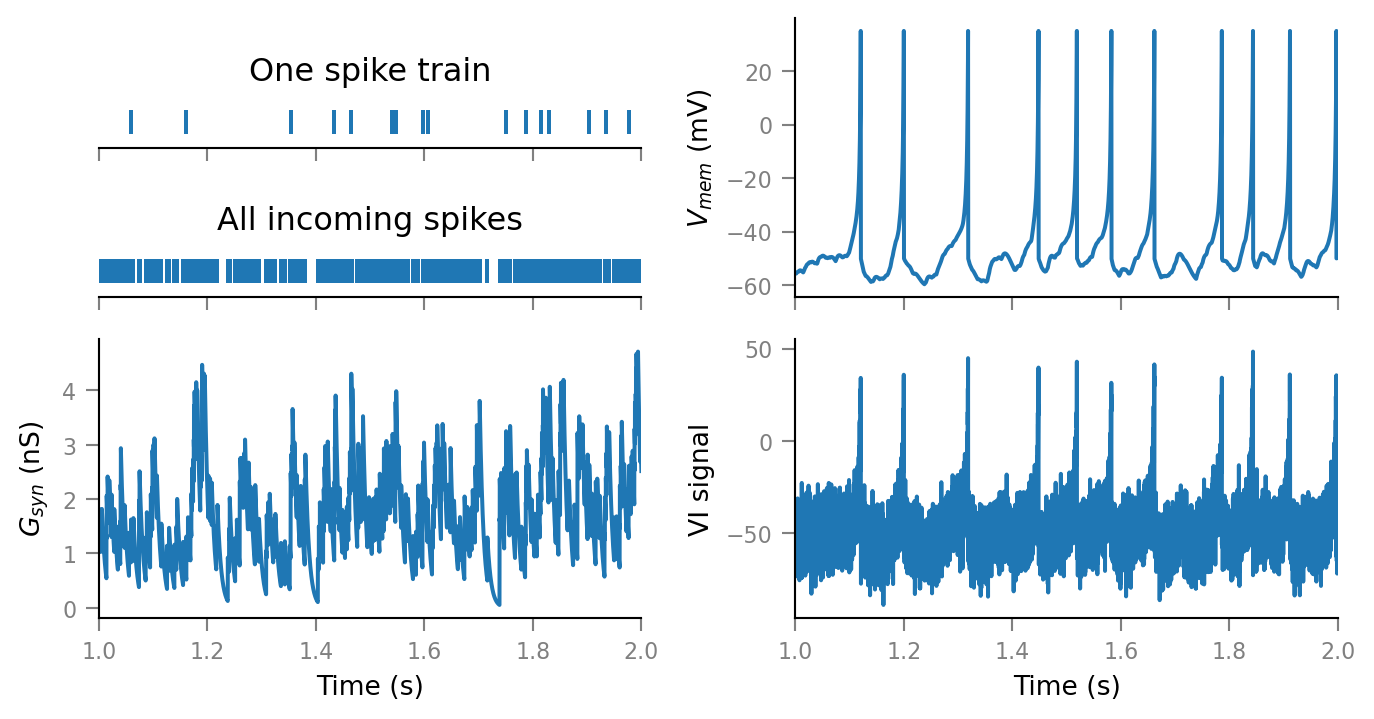

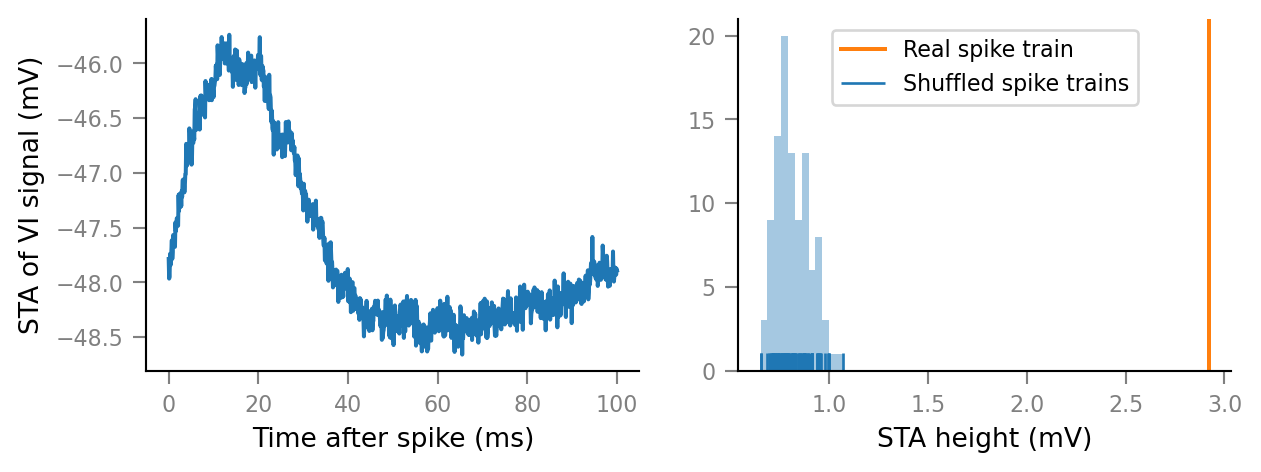

ConnectionTestSummary
---------------------
            p_value = 0.01
       p_value_type = '<'
relative_STA_height = 3.571


In [5]:
sim_and_test(default_sim_params)

## Short recording duration

In [6]:
from copy import deepcopy  # 'deep' to also make a copy of `time_grid`

sim_params = deepcopy(default_sim_params);

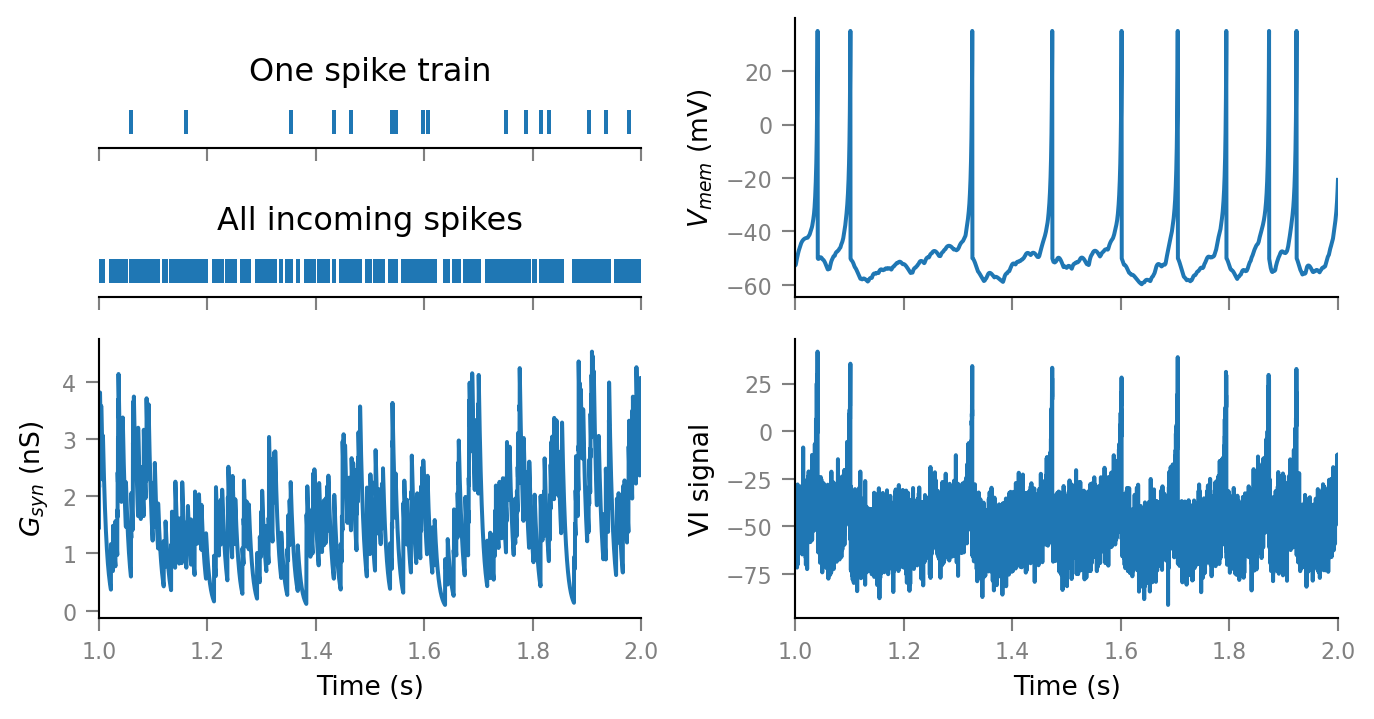

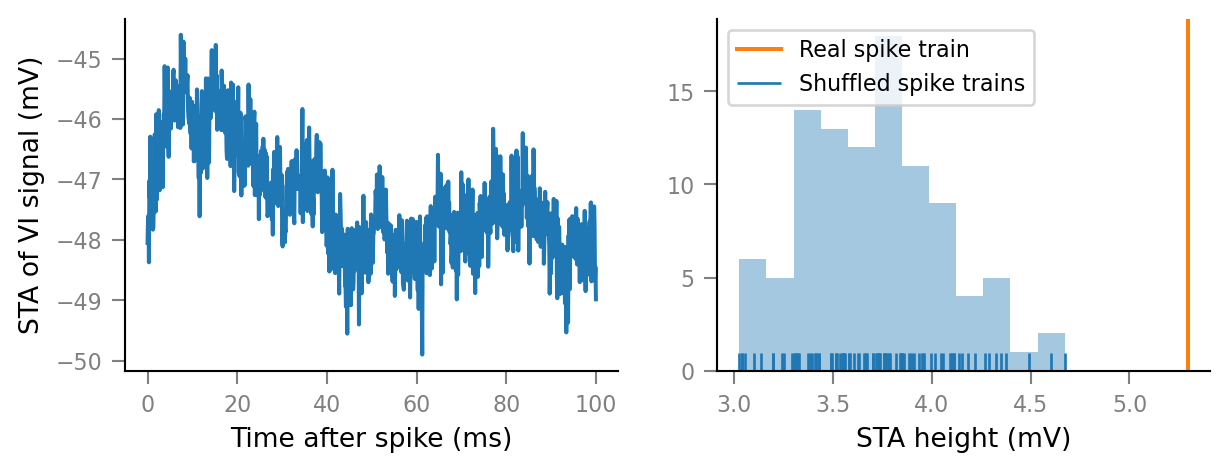

ConnectionTestSummary
---------------------
            p_value = 0.01
       p_value_type = '<'
relative_STA_height = 1.428


In [7]:
sim_params.time_grid.duration = 30 * second

sim_and_test(sim_params)

Still a PSP visible and the connection test can still find that the spike train is connected; but less convincing.

## Low number of incoming spike trains

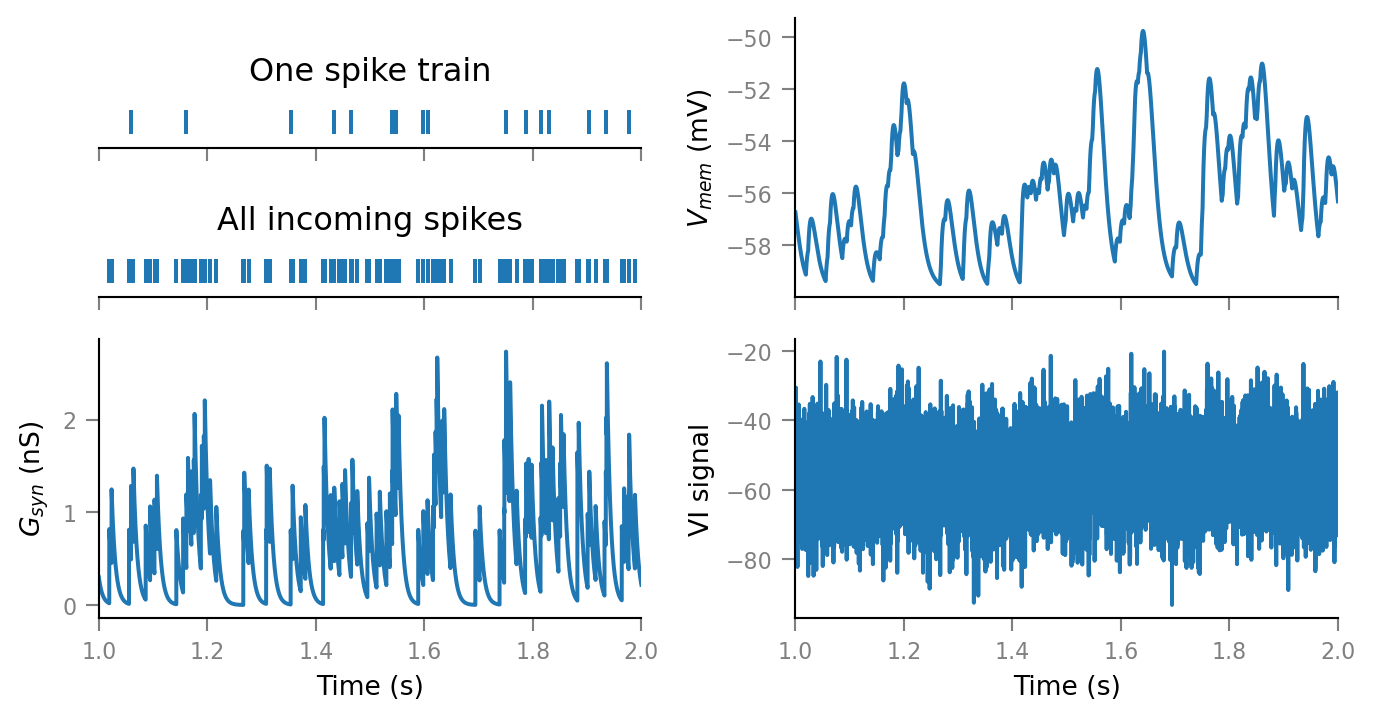

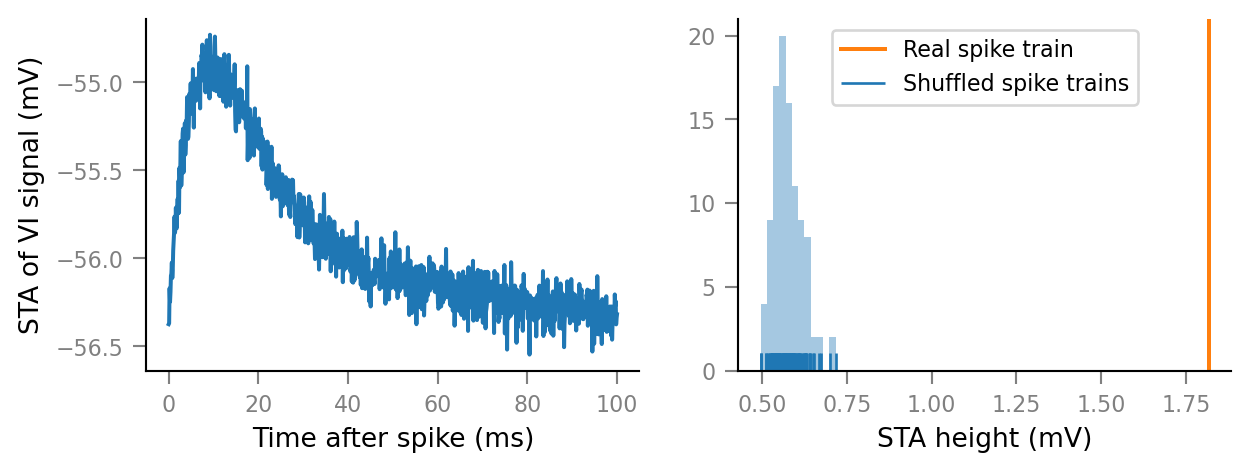

ConnectionTestSummary
---------------------
            p_value = 0.01
       p_value_type = '<'
relative_STA_height = 3.157


In [8]:
sim_params = deepcopy(default_sim_params)

sim_params.num_incoming_spike_trains = 5

sim_and_test(sim_params)

No spikes (not enough input); but still a PSP.

Note though that the STA shape is different now: no after-hyperpolarisation because no spikes.

## Fast spiking

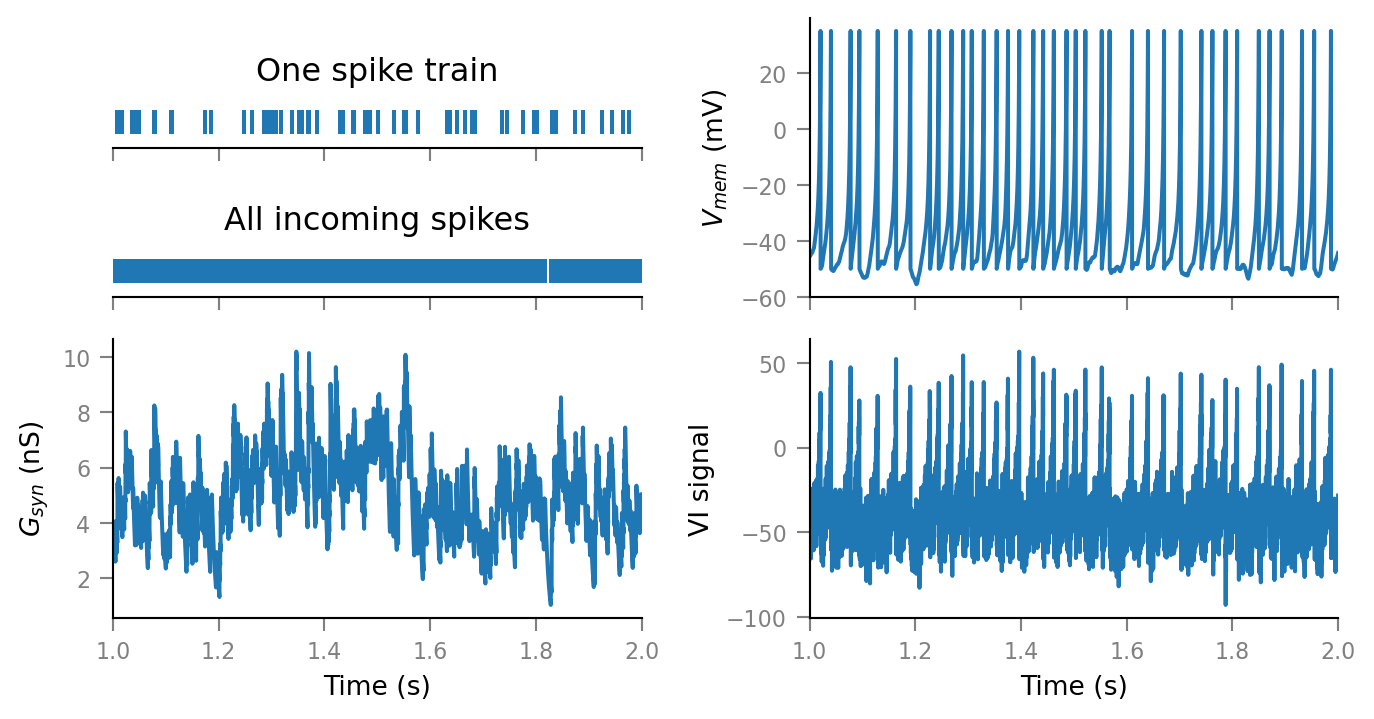

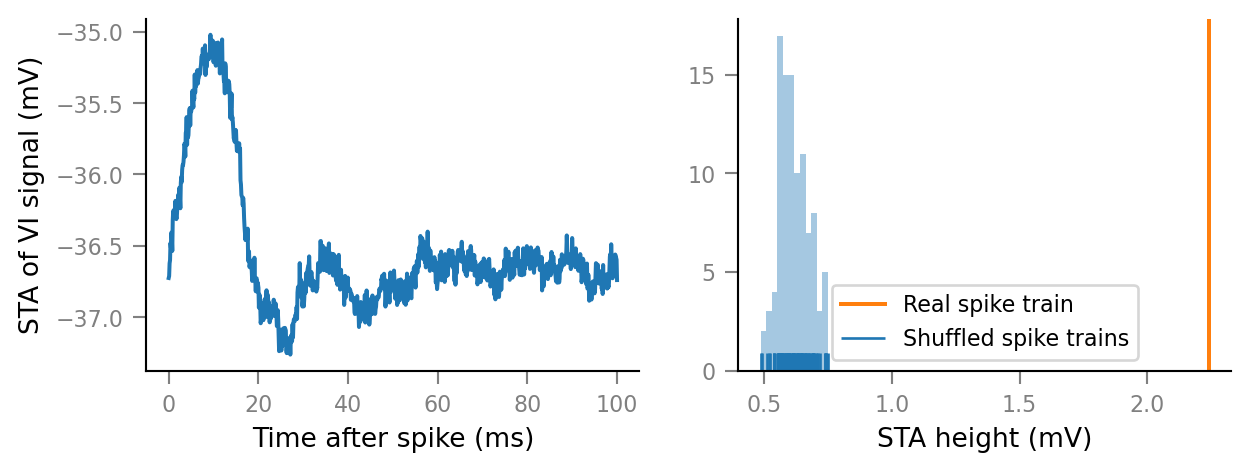

ConnectionTestSummary
---------------------
            p_value = 0.01
       p_value_type = '<'
relative_STA_height = 3.632


In [13]:
sim_params = deepcopy(default_sim_params)

sim_params.spike_rate = 60 * Hz

sim_and_test(sim_params)

Interesting: STA shape is more time-compressed.

There's maybe even some oscillation visible?

## Noisy imaging

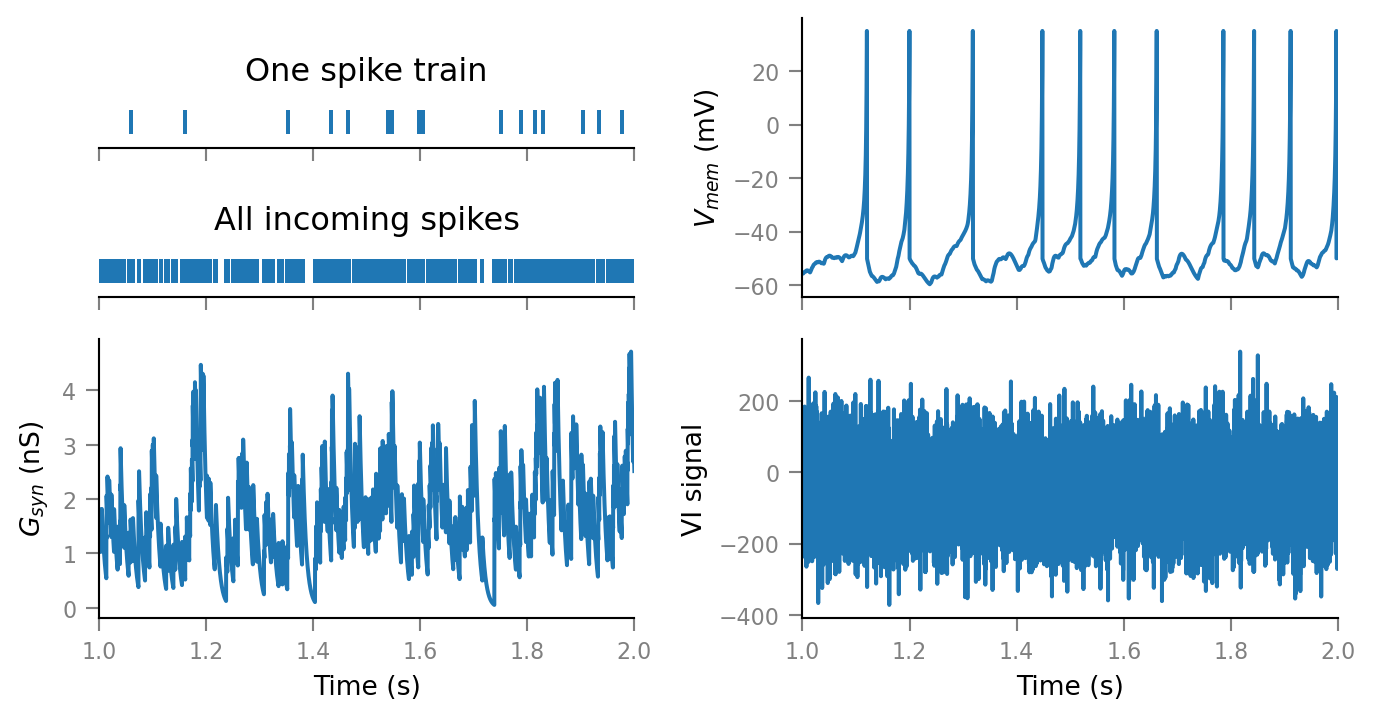

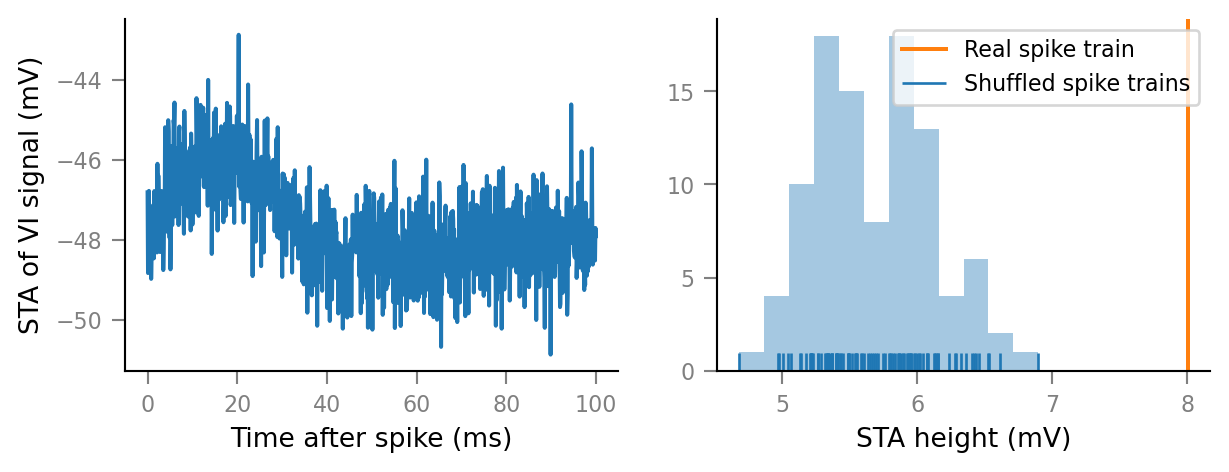

ConnectionTestSummary
---------------------
            p_value = 0.01
       p_value_type = '<'
relative_STA_height = 1.405


In [10]:
sim_params = deepcopy(default_sim_params)

sim_params.imaging_spike_SNR = 1

sim_and_test(sim_params)

Interesting: with strong noise (here: as strong as spike height), we can still resolve the PSPs.

## Noisy & short recording

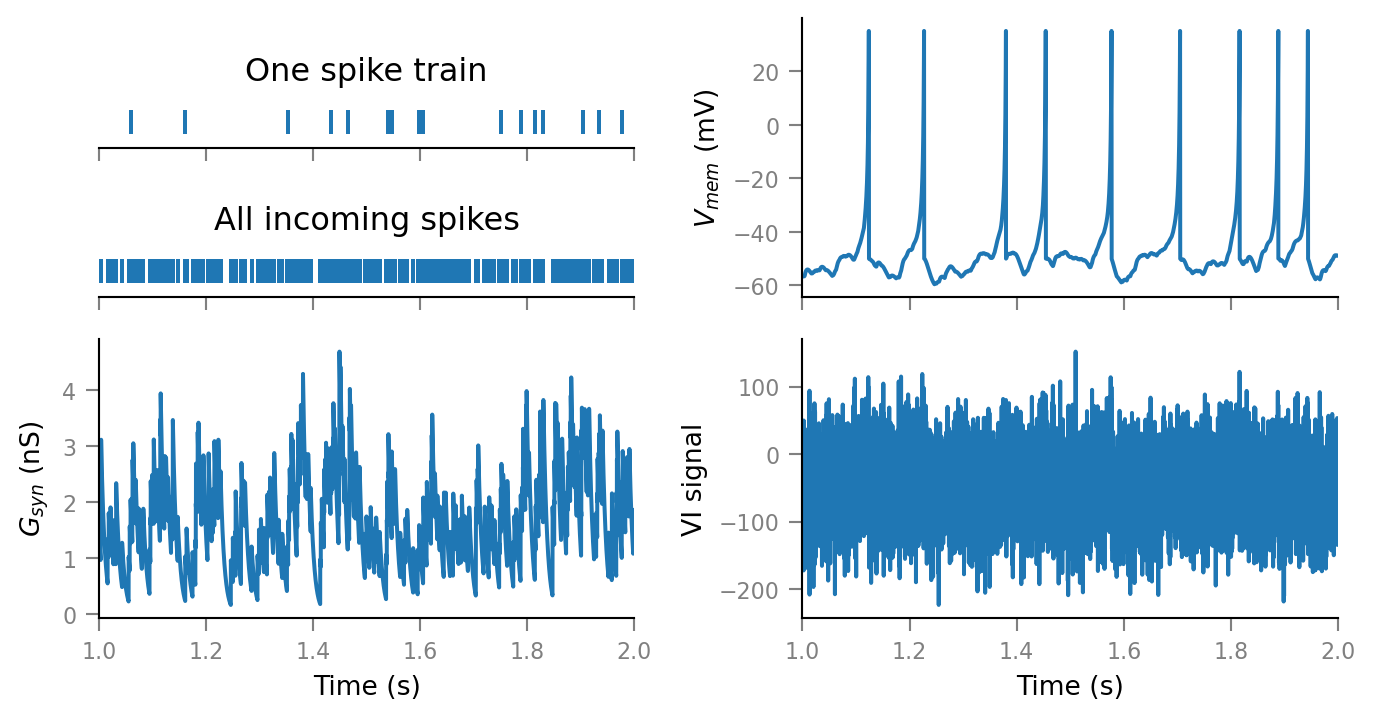

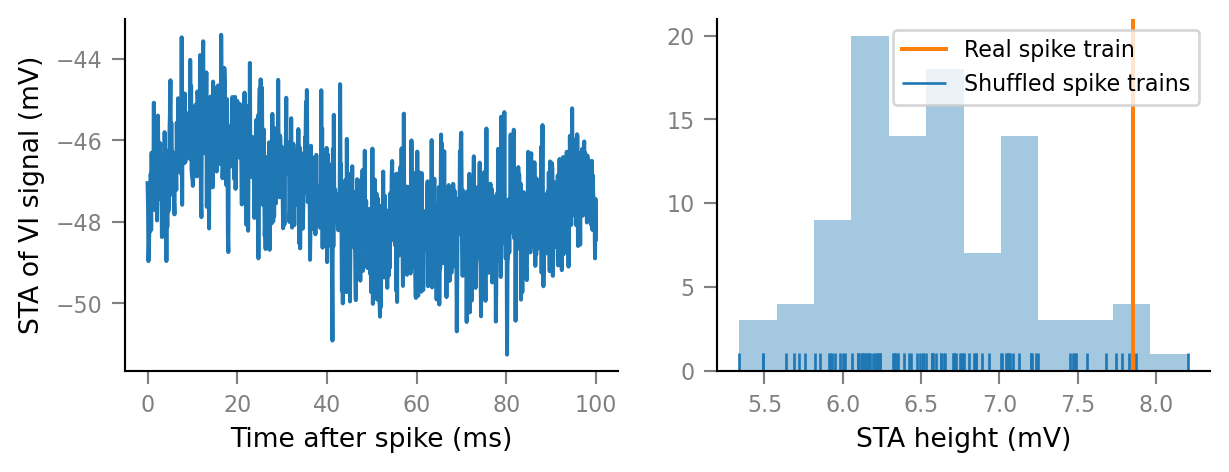

ConnectionTestSummary
---------------------
            p_value = 0.02
       p_value_type = '='
relative_STA_height = 1.195


In [11]:
sim_params = deepcopy(default_sim_params)

sim_params.time_grid.duration = 2 * minute
sim_params.imaging_spike_SNR = 2

sim_and_test(sim_params)

..but only when our recording is long enough.

Note that the PSP is still vaguely visible in the STA, however.

## Just for fun: no noise

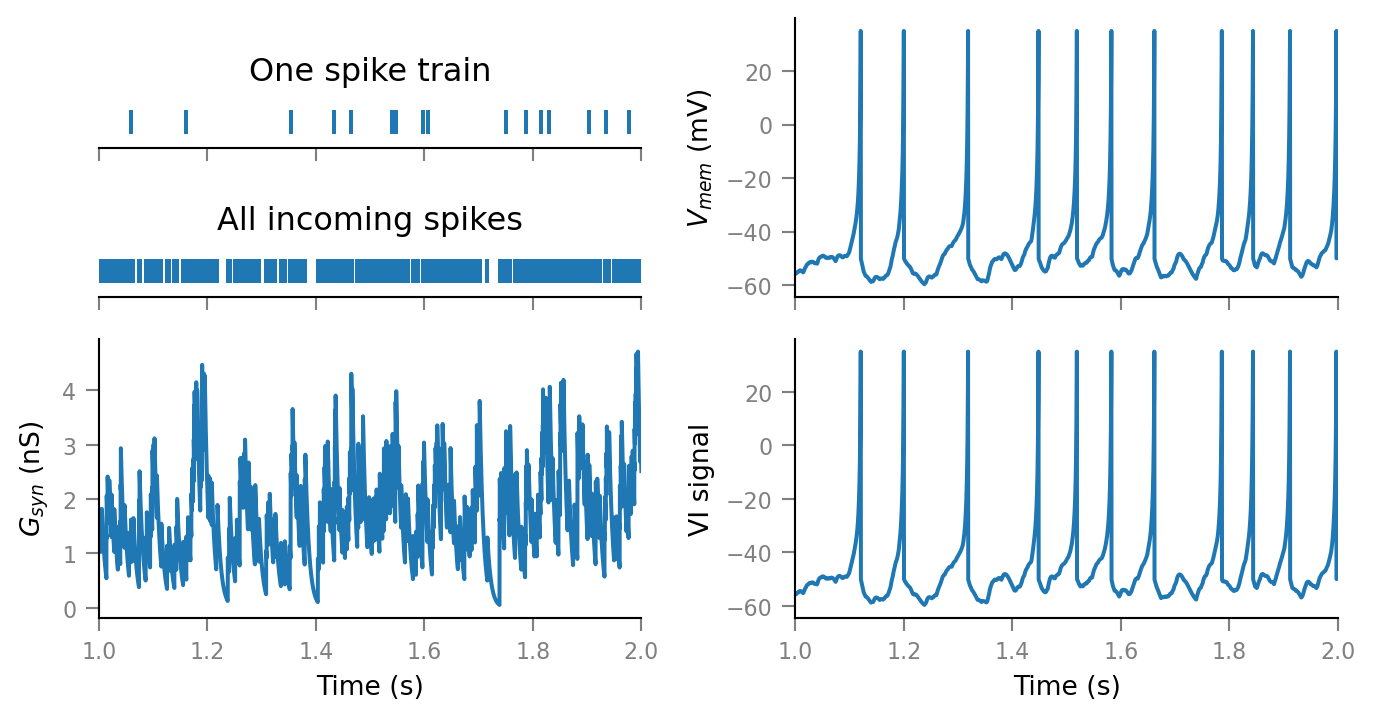

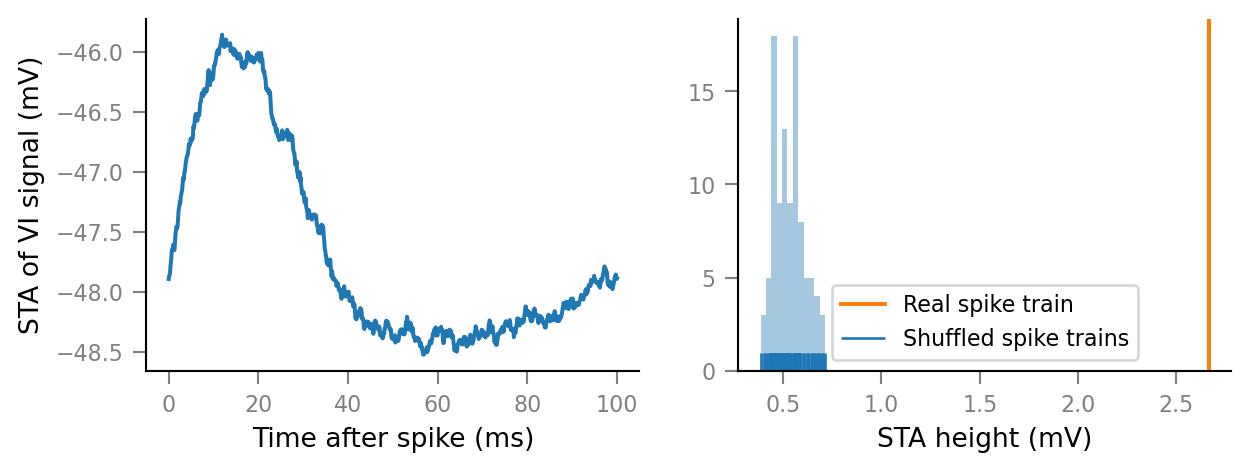

ConnectionTestSummary
---------------------
            p_value = 0.01
       p_value_type = '<'
relative_STA_height = 5.006


In [12]:
sim_params = deepcopy(default_sim_params)

sim_params.imaging_spike_SNR = np.inf

sim_and_test(sim_params)

## Reproducibility

In [152]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Fri 01 Jan** 2021, at 23:00 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/d5d0790cdb5a61a68872195e0d13b4121225903e
) (Fri 01 Jan 2021, 22:59).

Uncommited changes to:
```
?? notebooks/2020_12_30__vary_params.ipynb
```

Platform:

Windows-10
CPython 3.8.3 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.2
matplotlib           3.3.2
numba                0.51.2
seaborn              0.10.1
scipy                1.5.2
scikit-learn         0.23.2
preload              2.1
py-cpuinfo           7.0.0
nptyping             1.3.0
tqdm                 4.55.0
